In [1]:
import pandas as pd
import helpers
import get_groups_data
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
# load data from csv file to dataframes
BA_breweries = pd.read_csv('./data/BeerAdvocate/breweries.csv')
BA_beers = pd.read_csv('./data/BeerAdvocate/beers.csv')
BA_users = pd.read_csv('./data/BeerAdvocate/users.csv')
BA_groups = pd.read_csv('./data/BA_groups.csv')

# parse the ratings file to dataframe without textual description
RB_ratings = helpers.parse_reviews('./data/BeerAdvocate/ratings.txt','./data/BeerAdvocate')

In [3]:
# convert joined column to datetime
BA_users['joined'] = pd.to_datetime(BA_users['joined'], unit='s')


In [4]:
# drop the value without joined time - as there are only 0.04 % of such user
BA_users_validated = BA_users.dropna(subset='joined').copy()

# change Nan values to undefined label - as removing them from dataset will result in big information loss
BA_users_validated = BA_users_validated.fillna('Undefined')

BA_users_validated['user_id'] = BA_users_validated['user_id']

In [5]:
# removing columns with more than 90% of missing values
BA_beers_validated = BA_beers.drop(['zscore', 'avg_matched_valid_ratings'], axis=1).copy()

# removing beers that have 0 reviews
BA_beers_validated = BA_beers_validated[BA_beers_validated['nbr_ratings'] > 0]

# dropping beers with NaN values in columns 'avg', 'abv', 'avg_computes' as there are less than 10% of them
BA_beers_validated = BA_beers_validated.dropna(subset=['avg', 'abv', 'avg_computed'])

# encode remaining Nans in overall_score and style_score with 
BA_beers_validated = BA_beers_validated.fillna(-1)

In [6]:
# dropping row with missing values as there are only ~2.5% of them
BA_ratings_validated = RB_ratings.dropna().copy()

In [7]:
BA_groups_validated = BA_groups.drop(columns='Unnamed: 0')

In [8]:
# merge beers df with location of brewery that brewed it
BA_beers_with_brewery_location = BA_beers_validated.merge(BA_breweries[['location', 'id']], left_on='brewery_id', right_on='id', how='left')

# print columns of resulting df with percentage of missing values in each
print(BA_beers_with_brewery_location.isna().mean())

beer_id                      0.0
beer_name                    0.0
brewery_id                   0.0
brewery_name                 0.0
style                        0.0
nbr_ratings                  0.0
nbr_reviews                  0.0
avg                          0.0
ba_score                     0.0
bros_score                   0.0
abv                          0.0
avg_computed                 0.0
nbr_matched_valid_ratings    0.0
location                     0.0
id                           0.0
dtype: float64


In [9]:
BA_ratings_with_groups = BA_ratings_validated.merge(BA_groups_validated,
                                                    left_on=['brewery_name', BA_ratings_validated['date'].apply(lambda x: x.year)],
                                                    right_on=['brewery_name', 'year'],
                                                    how='left')

# replace name of group for other beers
BA_ratings_with_groups = BA_ratings_with_groups.fillna('Other')

# print columns of resulting df with percentage of missing values in each
print(BA_ratings_with_groups.isna().mean())

beer_name       0.0
beer_id         0.0
brewery_name    0.0
brewery_id      0.0
style           0.0
abv             0.0
date            0.0
user_name       0.0
user_id         0.0
appearance      0.0
aroma           0.0
palate          0.0
taste           0.0
overall         0.0
rating          0.0
year            0.0
group           0.0
main_group      0.0
dtype: float64


In [10]:
display(BA_ratings_with_groups.head())

# merge ratings_group df with information about users
BA_ratings_with_groups_and_users = BA_ratings_with_groups.merge(BA_users_validated[['joined', 'location', 'nbr_ratings', 'user_id']], on='user_id')
BA_ratings_with_groups_and_users = BA_ratings_with_groups_and_users.rename(columns={
    'nbr_ratings': 'total_user_nbr_ratings',
    'location': 'user_location',
    'joined': 'user_joined'
    })

# print columns of resulting df with percentage of missing values in each
print(BA_ratings_with_groups_and_users.isna().mean())

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,year,group,main_group
0,Stoudt's Blonde Double MaiBock,9906,Stoudts Brewing Co.,394,Maibock / Helles Bock,7.0,2009-04-27 10:00:00,atsprings,atsprings.94142,3.5,3.5,4.0,3.5,4.0,3.65,2009,Other,Other
1,Stoudt's Blonde Double MaiBock,9906,Stoudts Brewing Co.,394,Maibock / Helles Bock,7.0,2009-04-19 10:00:00,tr4nc3d,tr4nc3d.232958,4.0,4.0,4.0,4.0,4.0,4.00,2009,Other,Other
2,Stoudt's Blonde Double MaiBock,9906,Stoudts Brewing Co.,394,Maibock / Helles Bock,7.0,2009-04-07 10:00:00,Jayli,jayli.193663,4.0,3.5,4.0,4.0,4.0,3.88,2009,Other,Other
3,Stoudt's Blonde Double MaiBock,9906,Stoudts Brewing Co.,394,Maibock / Helles Bock,7.0,2009-04-02 10:00:00,TheManiacalOne,themaniacalone.37950,4.0,4.0,4.0,4.5,4.5,4.30,2009,Other,Other
4,Stoudt's Blonde Double MaiBock,9906,Stoudts Brewing Co.,394,Maibock / Helles Bock,7.0,2009-03-31 10:00:00,BARFLYB,barflyb.181122,4.0,3.0,4.0,4.5,4.0,3.96,2009,Other,Other


beer_name                 0.0
beer_id                   0.0
brewery_name              0.0
brewery_id                0.0
style                     0.0
abv                       0.0
date                      0.0
user_name                 0.0
user_id                   0.0
appearance                0.0
aroma                     0.0
palate                    0.0
taste                     0.0
overall                   0.0
rating                    0.0
year                      0.0
group                     0.0
main_group                0.0
user_joined               0.0
user_location             0.0
total_user_nbr_ratings    0.0
dtype: float64


In [11]:
# inner merge breweries with groups that own it
# equivalent to selecting only InBev breweries from dataset
BA_group_breweries = BA_breweries.merge(BA_groups_validated, left_on='name', right_on='brewery_name') 

In [12]:
display(BA_beers_with_brewery_location)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,nbr_matched_valid_ratings,location,id
0,142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),Euro Pale Lager,1,1,2.88,-1.0,-1.0,4.5,2.880000,0,Gabon,37262
1,19590,Barelegs Brew,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4,4,3.85,-1.0,-1.0,4.5,3.845000,0,Northern Ireland,10093
2,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,75,59,3.45,80.0,80.0,4.8,3.439867,59,Northern Ireland,10093
3,20841,St. Patrick's Ale,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,8,6,3.86,-1.0,-1.0,6.0,3.888750,6,Northern Ireland,10093
4,20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,English Bitter,64,48,3.56,82.0,90.0,4.2,3.556094,48,Northern Ireland,10093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217102,19149,Diamond Stout,885,Summit Station Restaurant & Brewery,Irish Dry Stout,3,3,3.83,-1.0,-1.0,6.5,3.830000,0,"United States, Maryland",885
217103,19142,IPA,885,Summit Station Restaurant & Brewery,English India Pale Ale (IPA),2,2,3.24,-1.0,-1.0,5.6,3.240000,0,"United States, Maryland",885
217104,19141,Irvington Pale Ale,885,Summit Station Restaurant & Brewery,American Pale Ale (APA),3,3,3.60,-1.0,-1.0,6.8,3.596667,0,"United States, Maryland",885
217105,19139,Kölsch Ale,885,Summit Station Restaurant & Brewery,Kölsch,3,3,2.71,-1.0,-1.0,5.0,2.713333,0,"United States, Maryland",885


In [13]:
display(BA_ratings_with_groups_and_users)
print(BA_ratings_with_groups_and_users.columns)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,palate,taste,overall,rating,year,group,main_group,user_joined,user_location,total_user_nbr_ratings
0,Stoudt's Blonde Double MaiBock,9906,Stoudts Brewing Co.,394,Maibock / Helles Bock,7.00,2009-04-27 10:00:00,atsprings,atsprings.94142,3.5,...,4.0,3.5,4.0,3.65,2009,Other,Other,2006-08-24 10:00:00,"United States, North Carolina",1368
1,Stoudt's Double IPA (India Pale Ale),20470,Stoudts Brewing Co.,394,American Double / Imperial IPA,9.43,2007-04-09 10:00:00,atsprings,atsprings.94142,4.0,...,4.0,4.5,4.0,4.32,2007,Other,Other,2006-08-24 10:00:00,"United States, North Carolina",1368
2,Stoudt's Fat Dog (Imperial Oatmeal Stout),20539,Stoudts Brewing Co.,394,Oatmeal Stout,8.00,2007-04-21 10:00:00,atsprings,atsprings.94142,4.0,...,3.5,4.5,4.0,4.15,2007,Other,Other,2006-08-24 10:00:00,"United States, North Carolina",1368
3,Stoudt's Scarlet Lady ESB,1622,Stoudts Brewing Co.,394,Extra Special / Strong Bitter (ESB),5.00,2009-03-13 11:00:00,atsprings,atsprings.94142,4.0,...,4.0,3.5,3.5,3.58,2009,Other,Other,2006-08-24 10:00:00,"United States, North Carolina",1368
4,Stoudt's Triple (Belgian Abbey-Style Ale),20746,Stoudts Brewing Co.,394,Tripel,9.00,2007-08-28 10:00:00,atsprings,atsprings.94142,3.5,...,3.5,4.0,3.5,3.70,2007,Other,Other,2006-08-24 10:00:00,"United States, North Carolina",1368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489630,Old Abominable,30213,Stoudts Brewing Co.,394,English Barleywine,9.00,2007-01-02 11:00:00,Hunture,hunture.75038,2.5,...,4.0,3.5,4.5,3.45,2007,Other,Other,2006-04-17 10:00:00,"United States, Pennsylvania",1
4489631,Pumpkinfest Lager,75683,Stoudts Brewing Co.,394,Fruit / Vegetable Beer,4.50,2015-02-05 11:00:00,careystoudt,careystoudt.868998,4.5,...,4.5,4.5,4.5,4.50,2015,Other,Other,2014-09-25 10:00:00,"United States, Vermont",1
4489632,Smooth Hoperator,36670,Stoudts Brewing Co.,394,Doppelbock,7.00,2011-04-28 10:00:00,hopmonsterIPA,hopmonsteripa.179263,4.5,...,3.5,4.0,4.5,4.32,2011,Other,Other,2007-12-14 11:00:00,"United States, Virginia",1
4489633,Smooth Hoperator,36670,Stoudts Brewing Co.,394,Doppelbock,7.00,2007-05-11 10:00:00,TKNOGRL,tknogrl.137159,4.5,...,4.0,4.5,4.0,4.23,2007,Other,Other,2007-05-05 10:00:00,"United States, Pennsylvania",1


Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'year', 'group', 'main_group',
       'user_joined', 'user_location', 'total_user_nbr_ratings'],
      dtype='object')


In [14]:
display(BA_group_breweries)

,id,location,name,nbr_beers,year,brewery_name,group,main_group
0,297,Northern Ireland,Thomas Caffrey Brewing Co.,2,2002,Thomas Caffrey Brewing Co.,Coors,MolsonCoors
1,297,Northern Ireland,Thomas Caffrey Brewing Co.,2,2003,Thomas Caffrey Brewing Co.,Coors,MolsonCoors
2,297,Northern Ireland,Thomas Caffrey Brewing Co.,2,2004,Thomas Caffrey Brewing Co.,Coors,MolsonCoors
3,297,Northern Ireland,Thomas Caffrey Brewing Co.,2,2005,Thomas Caffrey Brewing Co.,MolsonCoors,MolsonCoors
4,297,Northern Ireland,Thomas Caffrey Brewing Co.,2,2006,Thomas Caffrey Brewing Co.,MolsonCoors,MolsonCoors
...,...,...,...,...,...,...,...,...
3437,633,Poland,Browary Dolno&#347;l&#261;skie Piast S.A.,3,2013,Browary Dolno&#347;l&#261;skie Piast S.A.,Carlsberg,Carslberg
3438,633,Poland,Browary Dolno&#347;l&#261;skie Piast S.A.,3,2014,Browary Dolno&#347;l&#261;skie Piast S.A.,Carlsberg,Carslberg
3439,633,Poland,Browary Dolno&#347;l&#261;skie Piast S.A.,3,2015,Browary Dolno&#347;l&#261;skie Piast S.A.,Carlsberg,Carslberg
3440,633,Poland,Browary Dolno&#347;l&#261;skie Piast S.A.,3,2016,Browary Dolno&#347;l&#261;skie Piast S.A.,Carlsberg,Carslberg


In [15]:
years_comparison = BA_group_breweries.groupby(['year', 'group']).nunique().loc[: , ['brewery_name']]
display(years_comparison)

brewery_name
year group                    
2000 AB                      1
     Ambev                   4
     Asahi                   2
     Carlsberg              41
     Coors                   2
...                        ...
2017 Asahi                  16
     Carlsberg              45
     Diageo                  8
     Heineken               71
     MolsonCoors            24

[154 rows x 1 columns]

In [16]:
years_comparison.unstack(level=1).droplevel(0, axis=1).fillna(0).astype('int').to_csv('group_breweries_across_years.csv')

In [20]:
for group in BA_group_breweries['group'].unique():
    group_location_df = (BA_group_breweries[BA_group_breweries['group'] == group].groupby(['year', 'location'])
        .count().loc[: , ['brewery_name']].unstack(level=1).droplevel(0, axis=1).fillna(0).astype('int')).T
    
    US_breweries = group_location_df[group_location_df.index.str.contains('United States')].sum()
    US_states = group_location_df[group_location_df.index.str.contains('United States')].index
    group_location_df = group_location_df.drop(US_states)
    group_location_df.loc['United States'] = US_breweries
    group_location_df.to_csv(f'./plot_data/BA/breweries_countries/all_years/{group}.csv')
    if 2017 in group_location_df.columns:
        group_location_df[2017].to_csv(f'./plot_data/BA/breweries_countries/only_2017/{group}.csv')

Text(0.5, 1.0, 'Number of breweries owned by group')

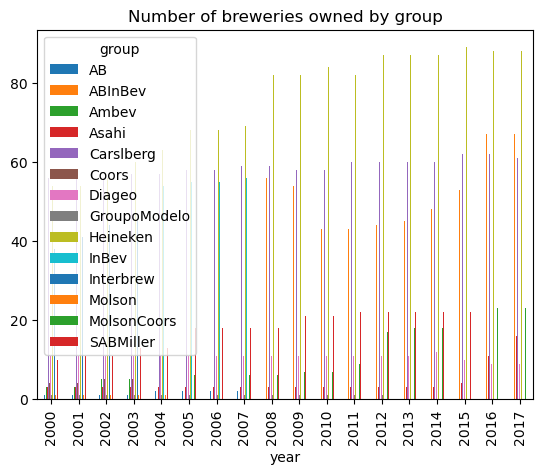

In [19]:
years_comparison['brewery_name'].unstack().plot(kind='bar')
plt.rcParams["figure.figsize"] = (30,20)
plt.title('Number of breweries owned by group')

# sns.catplot(data=years_comparison, x='year', y='brewery_name', hue='main_group', color='#eb9e34', kind='bar')
# plt.xticks(rotation=90)
# plt.show()

,beer_name
main_group,
Asahi,2545
Carslberg,11355
Diageo,15996
Heineken,52027
InBev,123917
MolsonCoors,36361
Other,4247434


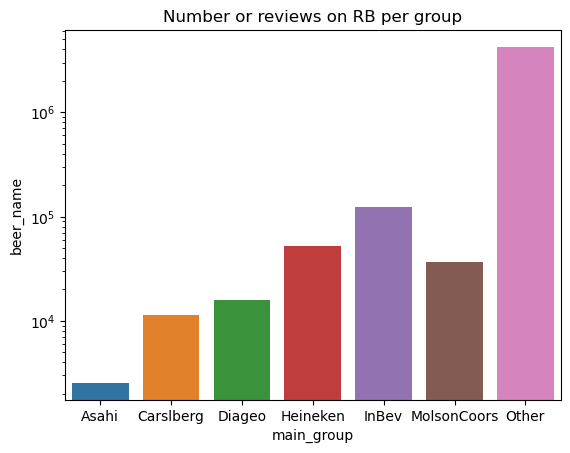

In [18]:
number_of_groups_reviews = (BA_ratings_with_groups_and_users.groupby('main_group').count()['beer_name']).to_frame()
display(number_of_groups_reviews)
sns.barplot(number_of_groups_reviews, x=number_of_groups_reviews.index, y='beer_name')
plt.rcParams["figure.figsize"] = (5,4)
plt.title('Number or reviews on RB per group')
plt.yscale('log')
number_of_groups_reviews.to_csv('nb_of_reviews.csv')

In [19]:
display(BA_ratings_with_groups_and_users[BA_ratings_with_groups_and_users['year'] == 2016].groupby('main_group').count()['beer_name'] / len(BA_ratings_with_groups_and_users[BA_ratings_with_groups_and_users['year'] == 2016].index))

main_group
Asahi          0.001126
Carslberg      0.001379
Diageo         0.002587
Heineken       0.014631
InBev          0.024460
MolsonCoors    0.011005
Other          0.944811
Name: beer_name, dtype: float64

In [22]:
financial_results_df = pd.read_csv('./data/finacial_results(USD).csv', header=0, index_col=0)
display(financial_results_df)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Molson-Coors,2.414415e+09,2.429462e+09,3.776322e+09,4.000113e+09,4.305816e+09,5.506906e+09,5.844985e+09,6.190592e+09,4774300000,3032400000,3254400000,3515700000,3916500000,4206100000,4146300000,3567500000,4885000000
AB inBev,5.317204e+09,6.499492e+09,7.341600e+09,8.875440e+09,1.165248e+10,1.375408e+10,1.756656e+10,2.106780e+10,22542800000,33862000000,36297000000,39046000000,39758000000,43195000000,47063000000,43604000000,45517000000
Heineken,7.620580e+09,8.155070e+09,1.080765e+10,1.166130e+10,1.252152e+10,1.141296e+10,1.393392e+10,1.641770e+10,20046600000,21022430000,21618220000,22088670000,24265560000,26500140000,23300970000,22356990000,21831600000
Carlsberg,3.206250e+09,4.061442e+09,4.976160e+09,5.817168e+09,6.639972e+09,6.049473e+09,7.264611e+09,8.815750e+09,11329416000,11460919000,10689612000,11075274000,11831304000,12245568000,10578984000,9313038000,8828574000
Asahi,9.862151e+09,8.406746e+09,8.901297e+09,1.033324e+10,1.050740e+10,8.698677e+09,8.465451e+09,9.061463e+09,10967099900,10293897722,11458920044,11972681215,10644621421,8796864608,7866032540,8092438679,8349863201
Diageo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2480394000,3318440400,3313464000,3348279000,3641729700,3940225800,3200496000,2861119800,2321379000


In [23]:
group_year_countries = dict()
for year in range(2000, 2017):
    group_year_countries[year] = dict()
    for group in BA_group_breweries['group'].unique():
        group_df = (BA_group_breweries[(BA_group_breweries['year'] == year) & (BA_group_breweries['group'] == group)].loc[:, ['brewery_name', 'location']])
        group_df = group_df.groupby('location').count()
        if len(group_df) > 0:
            group_year_countries[year][group] = list(group_df.itertuples(index=True, name=None))

print(group_year_countries)

{2000: {'Heineken': [('Bahamas', 1), ('Belarus', 1), ('Belgium', 1), ('Brazil', 1), ('Bulgaria', 1), ('Burundi', 1), ('China', 3), ('Congo', 1), ('Croatia', 1), ('Czech Republic', 1), ('Dem Rep of Congo', 1), ('England', 4), ('France', 3), ('Ghana', 1), ('Greece', 1), ('Hungary', 1), ('India', 1), ('Indonesia', 1), ('Ireland', 1), ('Italy', 1), ('Myanmar', 1), ('Netherlands', 2), ('Nigeria', 1), ('Papua New Guinea', 1), ('Poland', 5), ('Reunion', 1), ('Romania', 1), ('Rwanda', 1), ('Saint Lucia', 1), ('Scotland', 1), ('Serbia', 1), ('Sierra Leone', 1), ('Singapore', 1), ('Slovak Republic', 3), ('South Africa', 1), ('Spain', 2), ('Sri Lanka', 1), ('Switzerland', 1), ('Vietnam', 1)], 'Asahi': [('Australia', 1), ('China', 1), ('Japan', 1)], 'AB': [('United States, Missouri', 1)], 'Carslberg': [('Azerbaijan', 1), ('Belarus', 1), ('Bulgaria', 2), ('China', 6), ('Croatia', 1), ('Denmark', 3), ('Estonia', 1), ('Finland', 2), ('France', 1), ('Germany', 1), ('Italy', 1), ('Kazakhstan', 1), ('La

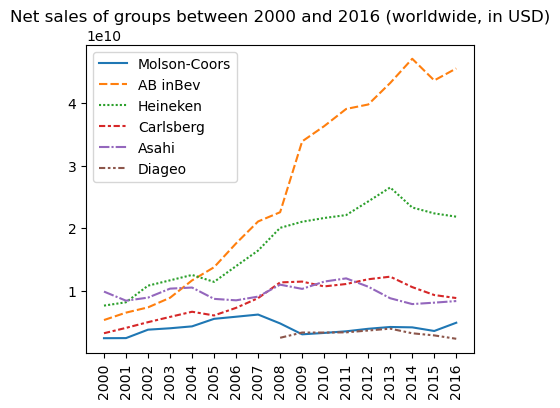

In [24]:
sns.lineplot(data=financial_results_df.T)
plt.title('Net sales of groups between 2000 and 2016 (worldwide, in USD)')
plt.xticks(rotation=90)
plt.show()

In [26]:
scipy.stats.pearsonr(
    BA_ratings_with_groups_and_users[BA_ratings_with_groups_and_users['main_group']=='InBev'].groupby('year').count()['beer_name'],
    financial_results_df.loc['AB inBev']
)

ValueError: x and y must have the same length.

In [27]:
scipy.stats.pearsonr(
    BA_ratings_with_groups_and_users[BA_ratings_with_groups_and_users['main_group']=='Carslberg'].groupby('year').count()['beer_name'],
    financial_results_df.loc['Carlsberg']
)

ValueError: x and y must have the same length.

In [ ]:
scipy.stats.pearsonr(
    BA_ratings_with_groups_and_users[BA_ratings_with_groups_and_users['main_group']=='Heineken'].groupby('year').count()['beer_name'],
    financial_results_df.loc['Heineken']
)

PearsonRResult(statistic=0.8624146969708686, pvalue=8.459972277764e-06)

In [ ]:
scipy.stats.pearsonr(
    BA_ratings_with_groups_and_users[BA_ratings_with_groups_and_users['main_group']=='MolsonCoors'].groupby('year').count()['beer_name'],
    financial_results_df.loc['Molson-Coors']
)

PearsonRResult(statistic=0.28367774396111267, pvalue=0.2698508528192913)

In [ ]:
import networkx as nx

# divide papers in treatment and control group based on fact of having (or no) the rebuttal (our treatment)
# treatment_df = RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['group'] != 'Other']
# control_df = RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['group'] == 'Other']

# treatment_df.to_pickle('tretment')
# control_df.to_pickle('control')

# print(len(treatment_df.index))
# print(len(control_df.index))

treatment_df = pd.read_pickle('tretment')
control_df = pd.read_pickle('control')

G = nx.Graph()

# add edges between points in treatment and control group only if they belong to the same track 
# and their overall_score_before_avg are the same
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():
        if (control_row['abv'] == treatment_row['abv']
            and control_row['style'] == treatment_row['style']):
            G.add_edges_from([(control_id, treatment_id)])

# perform maximal matching
matching = nx.maximal_matching(G)



In [2]:
from graph_tool.all import *
from tqdm import tqdm

divide papers in treatment and control group based on fact of having (or no) the rebuttal (our treatment)
treatment_df = RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['group'] != 'Other']
control_df = RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['group'] == 'Other']

treatment_df.to_pickle('tretment')
control_df.to_pickle('control')

print(len(treatment_df.index))
print(len(control_df.index))

treatment_df = pd.read_pickle('tretment')
control_df = pd.read_pickle('control')

g = Graph()

# add edges between points in treatment and control group only if they belong to the same track 
# and their overall_score_before_avg are the same
for control_id, control_row in tqdm(control_df.iterrows()):
    matched_data = treatment_df[(treatment_df['abv'] == control_row['abv']) & (treatment_df['group'] == control_row['group'])]
    for treatment_id, treatment_row in matched_data.iterrows():
        g.add_edge(control_id, treatment_id)


print('matching started')
# perform maximal matching
matching = max_cardinality_matching(g)


/home/kajotello/Anaconda3/envs/ada/lib/python3.9/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/kajotello/Anaconda3/envs/ada/lib/python3.9/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/kajotello/Anaconda3/envs/ada/lib/python3.9/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/kajotello/Anaconda3/envs/ada/lib/python3.9/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)
15958it [05:01, 52.97it/s]


KeyboardInterrupt: 